# Understanding Hired Rides in NYC


## Requirements

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project._

* Code clarity: make sure the code conforms to:
    * [ ] [PEP 8](https://peps.python.org/pep-0008/) - You might find [this resource](https://realpython.com/python-pep8/) helpful as well as [this](https://github.com/dnanhkhoa/nb_black) or [this](https://jupyterlab-code-formatter.readthedocs.io/en/latest/) tool
    * [ ] [PEP 257](https://peps.python.org/pep-0257/)
    * [ ] Break each task down into logical functions
* The following files are submitted for the project (see the project's GDoc for more details):
    * [ ] `README.md`
    * [ ] `requirements.txt`
    * [ ] `.gitignore`
    * [ ] `schema.sql`
    * [ ] 6 query files (using the `.sql` extension), appropriately named for the purpose of the query
    * [x] Jupyter Notebook containing the project (this file!)
* [x] You can edit this cell and add a `x` inside the `[ ]` like this task to denote a completed task

## Project Setup

In [88]:
# !pip install matplotlib
# !pip install  fastparquet==0.7.1
# !pip install geopandas
# !pip install shapely
# !pip install geopy
# !pip install keplergl==0.3.0

In [2]:
# all import statements needed for the project, for example:
from math import sin, cos, sqrt, atan2, radians
import requests
import re
import bs4
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import sqlalchemy as db
import geopandas as gpd
import os.path
import seaborn as sns
from keplergl import KeplerGl
from IPython.display import display
from PIL import Image
import numpy as np

In [90]:
# any general notebook setup, like log formatting


In [91]:
# any constants you might need, for example:

TAXI_URL = "https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

# add other constants to refer to any local data, e.g. uber & weather
UBER_CSV = "uber_rides_sample.csv"
weather_2009_CSV="2009_weather.csv"
weather_2010_CSV="2010_weather.csv"
weather_2011_CSV="2011_weather.csv"
weather_2012_CSV="2012_weather.csv"
weather_2013_CSV="2013_weather.csv"
weather_2014_CSV="2014_weather.csv"


NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

## Part 1: Data Preprocessing

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Define a function that calculates the distance between two coordinates in kilometers that **only uses the `math` module** from the standard library.
* [ ] Taxi data:
    * [ ] Use the `re` module, and the packages `requests`, BeautifulSoup (`bs4`), and (optionally) `pandas` to programmatically download the required CSV files & load into memory.
    * You may need to do this one file at a time - download, clean, sample. You can cache the sampling by saving it as a CSV file (and thereby freeing up memory on your computer) before moving onto the next file. 
* [ ] Weather & Uber data:
    * [ ] Download the data manually in the link provided in the project doc.
* [ ] All data:
    * [ ] Load the data using `pandas`
    * [ ] Clean the data, including:
        * Remove unnecessary columns
        * Remove invalid data points (take a moment to consider what's invalid)
        * Normalize column names
        * (Taxi & Uber data) Remove trips that start and/or end outside the designated [coordinate box](http://bboxfinder.com/#40.560445,-74.242330,40.908524,-73.717047)
    * [ ] (Taxi data) Sample the data so that you have roughly the same amount of data points over the given date range for both Taxi data and Uber data.
* [ ] Weather data:
    * [ ] Split into two `pandas` DataFrames: one for required hourly data, and one for the required daily daya.
    * [ ] You may find that the weather data you need later on does not exist at the frequency needed (daily vs hourly). You may calculate/generate samples from one to populate the other. Just document what you’re doing so we can follow along. 

### Calculating distance
For uber dataset, since there is no "distance" column, we need to calculate distance based on pickup's and dropoff's longitude and latitude. We use the euclidean distance between start and end coordinate. In order to keep datasets consistant, we ignore the "distance" column in yellow taxi dataset and calculate new "distance" column (using the same process as uber dataset does)

The function calculate_distance(picklon, picklat,droplon,droplat) will take pickup's and dropoff's longitudes and lantitudes, and then return the euclidean distance.

In [92]:
def calculate_distance(picklon, picklat,droplon,droplat):
    """Calculate distance from input lat/long and return distance (float)."""
    #return the euclidean distance between start and end coordinate
    R = 6373.0 #approximate radius of earth in km
    lon1=radians(abs(picklon))
    lat1=radians(abs(picklat))
    lon2=radians(abs(droplon))
    lat2=radians(abs(droplat))
    dlon=lon2-lon1
    dlat=lat2-lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    b = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance=R*b
    return distance

Function get_lon_lat(dataframe) is used to deal with taxi datasets, since some taxi datasets only contain location ID. We need to convert ID to latitude and longitude.get_lon_lat(dataframe) will return dataframe with four new columns "pickup_longitude","pickup_latitude","dropoff_longitude",and "dropoff_latitude".

In [93]:
def get_lon_lat(dataframe):
    """find lat/long from locationID and return dataframe with four new columns."""
    zone_file=gpd.read_file("taxi_zones")
    zone_file['geometry']=zone_file['geometry'].to_crs(4326)
    zone_file["lon"]=zone_file['geometry'].centroid.x
    zone_file["lat"]=zone_file['geometry'].centroid.y
    pick=zone_file[["LocationID","lon","lat"]]
    #rename columns
    pick.columns=["PULocationID","pickup_longitude","pickup_latitude"]
    drop=zone_file[["LocationID","lon","lat"]]
    #rename columns
    drop.columns=["DOLocationID","dropoff_longitude","dropoff_latitude"]
    #merge pick and drop to dataframe
    #merge pick 
    dataframe=pd.merge(left=dataframe,right=pick)
    #merge drop
    dataframe=pd.merge(left=dataframe,right=drop)
    return dataframe

Function add_distance_column(dataframe) will add new column "distance" through applying function calculate_distance to each row of the dataframe, which using columns "pickup_longitude","pickup_latitude","dropoff_longitude",and "dropoff_latitude".

In [94]:
def add_distance_column(dataframe):
    """Use function calculate_distance and return dataframe with distance column """
    dataframe["distance"]=dataframe.apply(lambda x: calculate_distance(x["pickup_longitude"]
                                                    ,x["pickup_latitude"],x["dropoff_longitude"],
                                                    x["dropoff_latitude"]),axis=1)
    return dataframe 

### Processing Taxi Data


After exploring yellow taxi datasets, we find that dataset's columns, column names, datatype are different among different year. Thus, we need to clean taxi data for following analysis.

First, we write a function called find_taxi_Parquet_urls, which will return urls for Parquet dataset from January 2009 through June 2015.

In [95]:
def find_taxi_Parquet_urls():
    """Web scraping using TAXI_URL, return list of urls for downloding yellow taxi data """
    url=TAXI_URL #url for taxi data page is set above
    url_list=list()
    response=requests.get(url)
    if response.status_code!=200:
        print("Failure: fail to request data")
        return result
    try:
        result_page=BeautifulSoup(response.content,'lxml')
        result_tags=result_page.find_all("a",{"title":re.compile('Yellow Taxi Trip.*')})
        for element in result_tags:
            newurl=element.get('href')
            url_list.append(newurl)
        #only include dataset link from January 2009 through June 2015 
        result=url_list[80:86]
        result.extend(url_list[92:]) 
    except:
        print("Failure: scraping fail")
    return result



In [96]:
#example of using find_taxi_Parquet_urls()
result=find_taxi_Parquet_urls()
result[0]

'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2016-12.parquet'

Function get_and_clean_month_taxi_data(url) will take one url for taxi parque as input. Then, it will normalize column name, normalize data type, drop null value, remove data point outside the coordinate box, and sampling the data based on uber dataset's size. The output of the function will be a cleaned dataframe

In [97]:
def get_and_clean_month_taxi_data(url):
    """Take one url for yellow taxi data, and return a cleaned taxi data"""
    #get month Taxi data
    df=pd.read_parquet(url,engine='fastparquet')
    """
    possible column name after looking at each dataset
    possible 1:['tpep_pickup_datetime',"trip_distance","PULocationID","DOLocationID","tip_amount"]
    possible 2:'pickup_datetime','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','tip_amount']
    possible 3:['Trip_Pickup_DateTime','Trip_Distance','Start_Lon', 'Start_Lat', 'End_Lon', 'End_Lat','Tip_Amt']
    """

    #deal with df.column contains possible 1
    if df.columns.str.contains('tpep_pickup_datetime').any():#df.column contain list1         
        #remove row with passenger_count=0
        df=df.loc[df.passenger_count!=0]
        #remove fare mount =0
        df=df.loc[df.fare_amount!=0]
        #select column
        df=df[["tpep_pickup_datetime","PULocationID","DOLocationID","tip_amount"]]
        #From taxi_zone, we know that loction ID is valid between 1 and 263. Thus, we can use it to clean our taxi dataset.
        #remove invalid locationID：location ID should between 1 and 263, and should be numeric
        df=df.loc[(df["PULocationID"]>=1) & (df["PULocationID"]<=263) & (df["DOLocationID"]>=1)
                & (df["DOLocationID"]<=263)]
       
        #only select pickup id not equal to drop off id, so that the disance will not be zero
        df=df.loc[df["PULocationID"]!=df["DOLocationID"]]
        #add longitude and latitude based on location ID
        df=get_lon_lat(df)
        #delete id
        del df["DOLocationID"]
        del df["PULocationID"]
        #rename 'tpep_pickup_datetime'
        df.rename(columns={"tpep_pickup_datetime": "pickup_datetime"}, inplace=True)
        
    #deal with df.column contains possible 2
    elif df.columns.str.contains('pickup_datetime').any():
        #remove row with passenger_count=0
        df=df.loc[df.passenger_count!=0]
        #remove fare mount =0
        df=df.loc[df.fare_amount!=0]
        df=df[['pickup_datetime','tip_amount','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']]
        #change pickup_datetime to datetime object 
        df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
        
    #deal with df.column contains possible 3    
    elif df.columns.str.contains('Trip_Pickup_DateTime').any():
        #remove row with passenger_count=0
        df=df.loc[df.Passenger_Count!=0]
        #remove fare mount =0
        df=df.loc[df.Fare_Amt!=0]
        df=df[['Trip_Pickup_DateTime','Tip_Amt','Start_Lon', 'Start_Lat', 'End_Lon', 'End_Lat']]
        df.rename(columns={"Trip_Pickup_DateTime": "pickup_datetime",'Start_Lon':'pickup_longitude', 
                           'Start_Lat':'pickup_latitude', 'End_Lon':'dropoff_longitude', 
                           'End_Lat':'dropoff_latitude','Tip_Amt':'tip_amount'}, inplace=True)
        #change pickup_datetime to datetime object 
        df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
        
    #remove outside the latitude/longitude coordinate box
    df=df.loc[(df["pickup_longitude"]<=-73.717047) & (df["pickup_longitude"]>=-74.242330) 
    & (df["pickup_latitude"]<=40.908524) & (df["pickup_latitude"]>=40.560445)
    & (df["dropoff_longitude"]<=-73.717047) & (df["dropoff_longitude"]>=-74.242330)
    & (df["dropoff_latitude"]<=40.908524)  & (df["dropoff_latitude"]>=40.560445)]

    #remove any row with nan value
    df.dropna(inplace=True)
    #remove Trips with zero passenger count
    
    #sample dataframe, since for uber dataset,roughly 2500 data per month.
    df=df.sample(n=2500,random_state = 1,ignore_index=True)
    
    return df



Function get_and_clean_taxi_data() will first find all url links. Then, each url link will be feed to function get_and_clean_month_taxi_data() to get a cleaned dataframe and add "distance" column to it. Finally, it concats all dataframes and return it as one gigantic dataframe.

In [98]:
def get_and_clean_taxi_data():
    """Return a combined dataframe containing all cleaned data for yellow taxi"""
    all_taxi_dataframes = []
    
    all_Parquet_urls = find_taxi_Parquet_urls()
    if os.path.exists('taxi_data.csv'):
        taxi_data=pd.read_csv('taxi_data.csv')
    else:        
        for Parquet_url in all_Parquet_urls:
            dataframe = get_and_clean_month_taxi_data(Parquet_url)
            #add distance column 
            dataframe=add_distance_column(dataframe)
            all_taxi_dataframes.append(dataframe)

        # create one gigantic dataframe with data from every month needed
        taxi_data = pd.concat(all_taxi_dataframes)
        #save file
        taxi_data.to_csv('taxi_data.csv',index=False)
    taxi_data=taxi_data.loc[taxi_data.distance!=0]
    return taxi_data

### Processing Uber Data


After exploring uber dataset, we notices that we need to change the column type for "pickuo_datatime" from object to dataobject. And then selected appropriate columns for futher analysis. We also explore the Uber dataset for each month. Uber datset contains around 2500 rows for each month. Thus, we use this number to sample yellow taxi dataset, which ensure that yellow taxi dataset contain rougly equal number of sample as the uber dataset does.

Function load_and_clean_uber_data(csv_file) takes the csv file name as an input. Then it only chooses columns "pickup_datetime","pickup_longitude","pickup_latitude","dropoff_longitude", and "dropoff_latitude" from the original dataset. After that, it normalize data type of 'pickup_datetime'. Finally, it will return a cleaned Uber dataset.

In [99]:
def load_and_clean_uber_data(csv_file):
    """It load uber dataset and return a cleaned dataframe"""
    df=pd.read_csv(csv_file)
    #clean data
    #pick column
    #remove row with zero passenger_count
    df=df.loc[df.passenger_count!=0]
    df=df.loc[df.fare_amount!=0]
    df=df[["pickup_datetime","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude"]]
    #column type
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime']).dt.tz_convert(None)
    
    #geobox
    df=df.loc[(df["pickup_longitude"]<=-73.717047) & (df["pickup_longitude"]>=-74.242330) 
    & (df["pickup_latitude"]<=40.908524) & (df["pickup_latitude"]>=40.560445)
    & (df["dropoff_longitude"]<=-73.717047) & (df["dropoff_longitude"]>=-74.242330)
    & (df["dropoff_latitude"]<=40.908524)  & (df["dropoff_latitude"]>=40.560445)]
    return df
    

Function get_uber_data() will return a cleaned dataset with one new column "distance" (using function add_distance_column()). 

In [100]:
def get_uber_data():
    """Add distance column to uber dataset, and return a dataframe"""
    if os.path.exists('uber_data.csv'):
        uber_dataframe=pd.read_csv('uber_data.csv')
    else:
        uber_dataframe = load_and_clean_uber_data(UBER_CSV)
        #add distance column
        uber_dataframe=add_distance_column(uber_dataframe)
        uber_dataframe=uber_dataframe.dropna()
        #store
        uber_dataframe.to_csv('uber_data.csv',index=False)
    uber_dataframe=uber_dataframe.loc[uber_dataframe.distance!=0]
    return uber_dataframe

### Processing Weather Data

By exploratory analysis and reading the description of dataset "weather", we found only rainfall of a day exceeds a threshold that can be measured, the filed hourly precipitation does contain a numeric value. Otherwise, it will be empty or a character "T". Hence, the first step is to replace the charater "T" to empty, and then tranform data type of hourly precipitation and hourly wind speed to number. After that, we convert data type of field date to datetime and drop all the all-null row in dataframe.

Function clean_month_weather_data_hourly(csv_file) takes the csv file name as an input. Then it only chooses columns "DATE","HourlyWindSpeed", and "HourlyPrecipitation" from the original dataset. After that, it clear the unrecognized value in HourlyPrecipitation and normalize data types of 'HourlyPrecipitation', 'HourlyWindSpeed' and 'DATE'. Finally, it will return a cleaned weather dataset.

In [101]:
def clean_month_weather_data_hourly(csv_file):
    df = pd.read_csv(csv_file)
    # only select columns will be used
    selected = df[['DATE', 'HourlyWindSpeed', 'HourlyPrecipitation']]
    # convert data type to number
    selected['HourlyPrecipitation'] = pd.to_numeric(selected['HourlyPrecipitation'].replace(['T'], ''), errors='coerce')
    selected['HourlyWindSpeed'] = pd.to_numeric(selected['HourlyWindSpeed'].replace(['T'], ''), errors='coerce')
    selected['DATE'] = pd.to_datetime(selected['DATE'])
    # filter na data
    selected = selected.dropna()
    return selected

Function clean_month_weather_data_daily(csv_file) takes the csv file name as an input. Then it only chooses columns "DATE", "HourlyWindSpeed", and "HourlyPrecipitation" from the original dataset. After that, it clears the unrecognized value in HourlyPrecipitation and normalize data types of 'HourlyPrecipitation', 'HourlyWindSpeed' and 'DATE'. Finally, it creates two new columns with mean value of hourly wind speed and sum value of hourly percipitation, and then return a cleaned daily weather data.

In [102]:
def clean_month_weather_data_daily(csv_file):
    df = pd.read_csv(csv_file)
    # only select columns will be used
    selected = df[['HourlyWindSpeed', 'HourlyPrecipitation', 'DATE']]
    # convert data type to number
    selected['HourlyPrecipitation'] = pd.to_numeric(selected['HourlyPrecipitation'].replace(['T'], ''), errors='coerce')
    selected['HourlyWindSpeed'] = pd.to_numeric(selected['HourlyWindSpeed'].replace(['T'], ''), errors='coerce')
    # filter na data
    selected = selected.dropna()
    # convert data time to date string
    selected['DATE'] = pd.to_datetime(selected['DATE']).dt.strftime('%Y-%m-%d')
    # get average wind speed and toal percipitation of each day
    daily_df = selected.groupby(['DATE']).agg({'HourlyWindSpeed': ['mean'], 'HourlyPrecipitation': ['sum']})
    # rename df
    daily_df.rename(columns = {'HourlyWindSpeed':'DailyWindSpeed', 'HourlyPrecipitation':'DailyPrecipitation'}, inplace = True)
    return daily_df.reset_index()

Function load_and_clean_weather_data() find all weather-like csv files in specified directory. For each weather file, it uses clean_month_weather_data_hourly and clean_month_weather_data_daily functions to clean data and append cleaned reult into two lists respectively. After that, it merges and returns all the cleaned dataset in each list to two dataframes.

In [103]:
def load_and_clean_weather_data():
    import warnings
    warnings.filterwarnings('ignore')
    
    hourly_dataframes = []
    daily_dataframes = []
    
    # read all weather-like files from given path
    import glob
    weather_csv_files = list(glob.glob('./*weather*.csv'))
    weather_csv_files.sort()

    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    
    return hourly_data, daily_data

### Process All Data

_This is where you can actually execute all the required functions._

Call the data process function to clean taxi trip data, uber trip data, hourly weather data and daily weather data.

In [104]:
taxi_data = get_and_clean_taxi_data()
uber_data = get_uber_data()
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()

## Part 2: Storing Cleaned Data


Based on sqlalchemy, this block is designed to connect sqlite service at first and then create tables with schema sqls, which is prepared based on the data type of all dataframes we cleaned before.

In [106]:
# create a db instance to do operation in db
engine = db.create_engine(DATABASE_URL)

In [107]:
# if using SQL (as opposed to SQLAlchemy), define the commands 
# to create your 4 tables/dataframes
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE hourly_weather(
   DATE timestamp PRIMARY KEY,
   HourlyWindSpeed FLOAT,
   HourlyPrecipitation FLOAT
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE daily_weather(
   DATE timestamp PRIMARY KEY,
   DailyWindSpeed FLOAT,
   DailyPrecipitation FLOAT
);
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE taxi_trips(
   pickup_datetime timestamp,
   tip_amount FLOAT,
   pickup_longitude DOUBLE,
   pickup_latitude DOUBLE,
   dropoff_longitude DOUBLE,
   dropoff_latitude DOUBLE,
   distance DOUBLE
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE uber_trips(
   pickup_datetime timestamp,
   pickup_longitude DOUBLE,
   pickup_latitude DOUBLE,
   dropoff_longitude DOUBLE,
   dropoff_latitude DOUBLE,
   distance DOUBLE
);
"""

In [108]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [109]:
# create the tables with the schema files
with engine.connect() as connection:
    pass

### Add Data to Database

Function write_dataframes_to_table(table_to_df_dict) first convert all dataframe to sqls and then export to sqlite instance table by table.

In [110]:
# convert df to sql and store data to db
def write_dataframes_to_table(table_to_df_dict):
    for table_name, df in table_to_df_dict.items():
        df.to_sql(name=table_name, con=engine.connect(), index=False, if_exists='replace')

In [111]:
# create a map between db table and dataframe
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather_data, 
    "daily_weather": daily_weather_data,
}

In [112]:
write_dataframes_to_table(map_table_name_to_dataframe)

## Part 3: Understanding the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins.
* [ ] For the same time frame, what day of the week was the most popular to take an uber? The result should have 7 bins.
* [ ] What is the 95% percentile of distance traveled for all hired trips during July 2013?
* [ ] What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?
* [ ] Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?
* [ ] During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

In [113]:
# write sql to file at specified direction
def write_query_to_file(query, outfile):
    with open(QUERY_DIRECTORY + '/' + str(outfile), "w") as f:
        f.write(query)

### Query 1

The query below first filter the taxi trips records between '2009-01-01' and '2015-06-30', and then count the records group by hour of pickup time of trip, and the result is ordered by hourly trip popularity.

In [114]:
QUERY_1 = """
select strftime('%H', pickup_datetime) as hour_of_day, count(1) as popularity
from taxi_trips
where strftime('%s', pickup_datetime) BETWEEN strftime('%s', '2009-01-01') AND strftime('%s', '2015-06-30')
group by strftime('%H', pickup_datetime)
order by popularity desc
"""

In [115]:
# get retrieval result of given sql
engine.execute(QUERY_1).fetchall()

[('19', 11899),
 ('18', 11564),
 ('20', 11311),
 ('21', 11015),
 ('22', 10690),
 ('17', 9664),
 ('23', 9583),
 ('14', 9558),
 ('13', 9445),
 ('12', 9320),
 ('15', 9110),
 ('11', 9077),
 ('09', 9041),
 ('08', 8739),
 ('10', 8430),
 ('16', 8011),
 ('00', 7631),
 ('07', 6869),
 ('01', 5499),
 ('02', 4282),
 ('06', 3838),
 ('03', 3130),
 ('04', 2195),
 ('05', 1886)]

The result shows 19:00 PM is most popular hour for yellow taxi.

### Query 2

The query below first filter the Uber trips records between '2009-01-01' and '2015-06-30', and then count the records group by day of pickup time of trip, and the result is ordered by daily trip popularity.

In [116]:
QUERY_2 = """
select count(1) as popularity, strftime('%w', pickup_datetime) as day_of_week
from uber_trips
where strftime('%s', pickup_datetime) BETWEEN strftime('%s', '2009-01-01') AND strftime('%s', '2015-06-30')
group by strftime('%w', pickup_datetime)
order by popularity desc
"""

In [117]:
# get retrieval result of given sql
engine.execute(QUERY_2).fetchall()

[(29749, '5'),
 (29213, '6'),
 (28960, '4'),
 (27971, '3'),
 (27088, '2'),
 (25503, '0'),
 (24280, '1')]

The result shows Friday is most popular weekday for uber.

### Query 3

The query below first union all taxis trips and uber trips. Secondly, it uses window function to sort all trips by distance and the rank will be add to result table. The final step is to find the distance value at or most near to the percentile 0.95.

In [118]:
QUERY_3 = """
with all_trips as (
    SELECT distance,
        pickup_datetime
    FROM taxi_trips
    where strftime('%Y-%m', pickup_datetime) == "2013-07"
    union all
    SELECT distance,
        pickup_datetime
    FROM uber_trips
    where strftime('%Y-%m', pickup_datetime) == "2013-07"
),
sorted_trips as (
    SELECT distance,
        pickup_datetime,
        ROW_NUMBER() OVER (ORDER BY distance DESC) AS rank
    FROM all_trips
)
select distance from sorted_trips
where rank = (select ROUND((count(1) - 1) * (1 - 0.95)) from sorted_trips where strftime('%Y-%M', pickup_datetime) == "2013-07")
"""

In [119]:
# get retrieval result of given sql
engine.execute(QUERY_3).fetchall()

[(23.237183431665876,)]

The trip distance that most near to the percentile 0.95 is 10621.171443418036

### Query 4
The query below first union all taxis trips and uber trips, and then calculate total trip count and average distance of each day in year 2009. Only the 10 days with top 10 trip popularity will be retrieved as result.

In [120]:
QUERY_4= """
with all_trips as (
    SELECT distance,
        pickup_datetime
    FROM taxi_trips
    where strftime('%Y', pickup_datetime) = '2009'
    union all
    SELECT distance,
        pickup_datetime
    FROM uber_trips
    where strftime('%Y', pickup_datetime) = '2009'
)
select strftime('%Y-%m-%d', pickup_datetime), count(1) as popularity, avg(distance) as avg_dist
from all_trips
group by strftime('%Y-%m-%d', pickup_datetime)
order by popularity desc
limit 10
"""

In [121]:
# get retrieval result of given sql
engine.execute(QUERY_4).fetchall()

[('2009-05-16', 223, 3.0836758398307227),
 ('2009-11-07', 214, 3.113487123299589),
 ('2009-06-19', 210, 3.1208384567147704),
 ('2009-12-11', 208, 3.007340067930742),
 ('2009-07-23', 208, 3.2332837723980226),
 ('2009-10-23', 207, 2.7143009476755764),
 ('2009-02-20', 205, 2.895127455826877),
 ('2009-09-19', 203, 3.1303408788652103),
 ('2009-03-10', 202, 3.035577979041243),
 ('2009-02-06', 202, 3.145587476114442)]

The result above shows the days with the highest number of hired rides for 2009
and the corressponding trips count, average distance that having highest trip popularity.

### Query 5
The query below first union all taxis trips and uber trips, and then left join the daily weather data to get daily wind speed and trip count of each day in year 2014.

In [122]:
QUERY_5= """
with weather as (
    select date, DailyWindSpeed from daily_weather 
    where strftime('%Y', date) = '2014'
    order by DailyWindSpeed desc
    limit 10
),
all_trip as (
    select pickup_datetime from taxi_trips
    where strftime('%Y', pickup_datetime) = '2014'
    union all
    select pickup_datetime from uber_trips
    where strftime('%Y', pickup_datetime) = '2014'
)
select date, max(DailyWindSpeed), count(1) as popularity
from weather
left join all_trip
on weather.date = strftime('%Y-%m-%d', all_trip.pickup_datetime)
group by weather.date
order by date asc
"""

In [123]:
# get retrieval result of given sql
engine.execute(QUERY_5).fetchall()

OperationalError: (sqlite3.OperationalError) no such column: date
[SQL: 
with weather as (
    select date, DailyWindSpeed from daily_weather 
    where strftime('%Y', date) = '2014'
    order by DailyWindSpeed desc
    limit 10
),
all_trip as (
    select pickup_datetime from taxi_trips
    where strftime('%Y', pickup_datetime) = '2014'
    union all
    select pickup_datetime from uber_trips
    where strftime('%Y', pickup_datetime) = '2014'
)
select date, max(DailyWindSpeed), count(1) as popularity
from weather
left join all_trip
on weather.date = strftime('%Y-%m-%d', all_trip.pickup_datetime)
group by weather.date
order by date asc
]
(Background on this error at: https://sqlalche.me/e/14/e3q8)

The result above shows the days were the windiest, and these days' trips count, average distance that having highest trip popularity.

### Query 6

The query below first union all taxis trips and uber trips, and then calculate total trip count of each day and hour. Secondly, the trip count result left join hourly weather data to get the hourly wind speed and hourly precipitation of each day and hour in previous step.

In [ ]:
QUERY_6= """
with all_trip as (
    select pickup_datetime from taxi_trips
    where strftime('%s', pickup_datetime) BETWEEN strftime('%s', '2012-10-22') AND strftime('%s', '2012-10-30')
    union all
    select pickup_datetime from uber_trips
    where strftime('%s', pickup_datetime) BETWEEN strftime('%s', '2012-10-22') AND strftime('%s', '2012-10-30')
),
trip_aggr as (
    select strftime('%Y-%m-%d:%H', pickup_datetime) as day_hour, count(1) as heat
    from all_trip
    group by strftime('%Y-%m-%d:%H', pickup_datetime)
)
select day_hour, heat, coalesce(HourlyWindSpeed, 0), coalesce(HourlyPrecipitation,0)
from trip_aggr
left join hourly_weather
on trip_aggr.day_hour = strftime('%Y-%m-%d:%H', hourly_weather.date)
"""

In [ ]:
# get retrieval result of given sql
engine.execute(QUERY_6).fetchall()

[('2012-10-22:00', 3, 7.0, 0.0),
 ('2012-10-22:01', 2, 5.0, 0.0),
 ('2012-10-22:02', 1, 7.0, 0.0),
 ('2012-10-22:03', 1, 0.0, 0.0),
 ('2012-10-22:05', 1, 0.0, 0.0),
 ('2012-10-22:06', 4, 5.0, 0.0),
 ('2012-10-22:07', 10, 3.0, 0.0),
 ('2012-10-22:08', 7, 3.0, 0.0),
 ('2012-10-22:09', 9, 5.0, 0.0),
 ('2012-10-22:10', 7, 0, 0),
 ('2012-10-22:11', 13, 0, 0),
 ('2012-10-22:12', 11, 11.0, 0.0),
 ('2012-10-22:13', 12, 0, 0),
 ('2012-10-22:14', 2, 7.0, 0.0),
 ('2012-10-22:15', 4, 6.0, 0.0),
 ('2012-10-22:16', 7, 3.0, 0.0),
 ('2012-10-22:17', 9, 7.0, 0.0),
 ('2012-10-22:18', 11, 5.0, 0.0),
 ('2012-10-22:19', 7, 5.0, 0.0),
 ('2012-10-22:20', 9, 3.0, 0.0),
 ('2012-10-22:21', 6, 0.0, 0.0),
 ('2012-10-22:22', 8, 3.0, 0.0),
 ('2012-10-22:23', 3, 3.0, 0.0),
 ('2012-10-23:00', 5, 0, 0),
 ('2012-10-23:01', 2, 0, 0),
 ('2012-10-23:05', 3, 0, 0),
 ('2012-10-23:06', 3, 0, 0),
 ('2012-10-23:07', 11, 0, 0),
 ('2012-10-23:08', 12, 0, 0),
 ('2012-10-23:09', 9, 0, 0),
 ('2012-10-23:10', 10, 0, 0),
 ('2012-10-2

The result above shows the days during Hurricane Sandy in NYC and the week leading up to it, and the trips were taken each hour as well the hourly wind speed and precipitation of these days.

In [ ]:
# store all the sqls as files
write_query_to_file(QUERY_1, "taxi_hourly_trip.sql")
write_query_to_file(QUERY_2, "uber_daily_trip.sql")
write_query_to_file(QUERY_3, "upper_trip_distance.sql")
write_query_to_file(QUERY_4, "2009_peak_ten.sql")
write_query_to_file(QUERY_5, "trip_count_windiest.sql")
write_query_to_file(QUERY_6, "Hurricane_Sandy.sql")

## Part 4: Visualizing the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Create an appropriate visualization for the first query/question in part 3
* [ ] Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization
* [ ] Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.
* [ ] Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.
* [ ] Create a scatter plot that compares tip amount versus distance.
* [ ] Create another scatter plot that compares tip amount versus precipitation amount.

_Be sure these cells are executed so that the visualizations are rendered when the notebook is submitted._

### Visualization N

_**TODO:** Write some prose that tells the reader what you're about to do here._

_Repeat for each visualization._

_The example below makes use of the `matplotlib` library. There are other libraries, including `pandas` built-in plotting library, kepler for geospatial data representation, `seaborn`, and others._

### Problem 1

In [ ]:
# use a more descriptive name for your function
def plot_visual_n(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))
    
    values = "..."  # use the dataframe to pull out values needed to plot
    
    # you may want to use matplotlib to plot your visualizations;
    # there are also many other plot types (other 
    # than axes.plot) you can use
    axes.plot(values, "...")
    # there are other methods to use to label your axes, to style 
    # and set up axes labels, etc
    axes.set_title("Some Descriptive Title")
    
    plt.show()

In [ ]:
def get_data_for_visual_n():
    # Query SQL database for the data needed.
    # You can put the data queried into a pandas dataframe, if you wish
    raise NotImplemented()

In [ ]:
some_dataframe = get_data_for_visual_n()
plot_visual_n(some_dataframe)

### Problem 2

### Problem 3

We choose to use bar plot to compare dropoff frequence for different weekday for different air port region, since bar plot can clearly show the . First, we only read data which dropoff latitude and longitude within the lat/long coordinate boxes around thee airports (finding through bboxfinder). Then we draw bar plot.

In [124]:
def plot_histograms_airport(df_jfk, df_lga,df_ewr):
    """Take in three dataframe and return three bar plots"""
    
    ax1=plt.subplot(311)
    ax1=sns.countplot(x="pickup_datetime",data=df_jfk)
    sns.set(rc={'figure.figsize':(10,18)})
    ax1.bar_label(ax1.containers[0])
    plt.xlabel("Weekday")
    plt.ylabel("Number of dropoff")
    ax1.set_title("Drop off number for weekdays (JFK)")  
    ax2=plt.subplot(312)
    ax2=sns.countplot(x="pickup_datetime",data=df_lga)
    ax2.bar_label(ax2.containers[0])
    plt.xlabel("Weekday")
    plt.ylabel("Number of dropoff")
    ax2.set_title("Drop off number for weekdays (LGA)") 
    ax3=plt.subplot(313)
    ax3=sns.countplot(x="pickup_datetime",data=df_ewr)
    ax3.bar_label(ax3.containers[0])
    plt.xlabel("Weekday")
    plt.ylabel("Number of dropoff")
    ax3.set_title("Drop off number for weekdays (EWR)") 
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=1,
                    wspace=0.4,
                    hspace=0.4)
    plt.show()

In [125]:
def get_data_for_airport():
    """Query data from taxi_trip, and return three dataset based on dropoff location"""
    jfk=[-73.827918,40.624822,-73.744148,40.669106]
    lga=[-73.890352,40.766242,-73.854218,40.785676]
    ewr=[-74.196339,40.667749,-74.149990,40.714476]
    
    # Query SQL database for the data needed.
    QUERY_airport="""
    SELECT pickup_datetime,dropoff_longitude,dropoff_latitude from taxi_trips
    """
    df=pd.read_sql_query(QUERY_airport,con=engine.connect())
    df["pickup_datetime"] =pd.to_datetime(df['pickup_datetime'])
    df["pickup_datetime"] = df["pickup_datetime"].apply(lambda x: x.weekday()+1)
    df_jfk=df.loc[(df["dropoff_longitude"]<=-73.744148) & (df["dropoff_longitude"]>=-73.827918)
    & (df["dropoff_latitude"]<=40.669106) & (df["dropoff_latitude"]>=40.624822)]
    df_lga=df.loc[(df["dropoff_longitude"]<=-73.854218) & (df["dropoff_longitude"]>=-73.890352)
    & (df["dropoff_latitude"]<=40.785676) & (df["dropoff_latitude"]>=40.766242)]
    df_ewr=df.loc[(df["dropoff_longitude"]<=-74.149990) & (df["dropoff_longitude"]>=-74.196339)
    & (df["dropoff_latitude"]<=40.714476) & (df["dropoff_latitude"]>=40.667749)]


    # You can put the data queried into a pandas dataframe, if you wish
    return df_jfk, df_lga,df_ewr

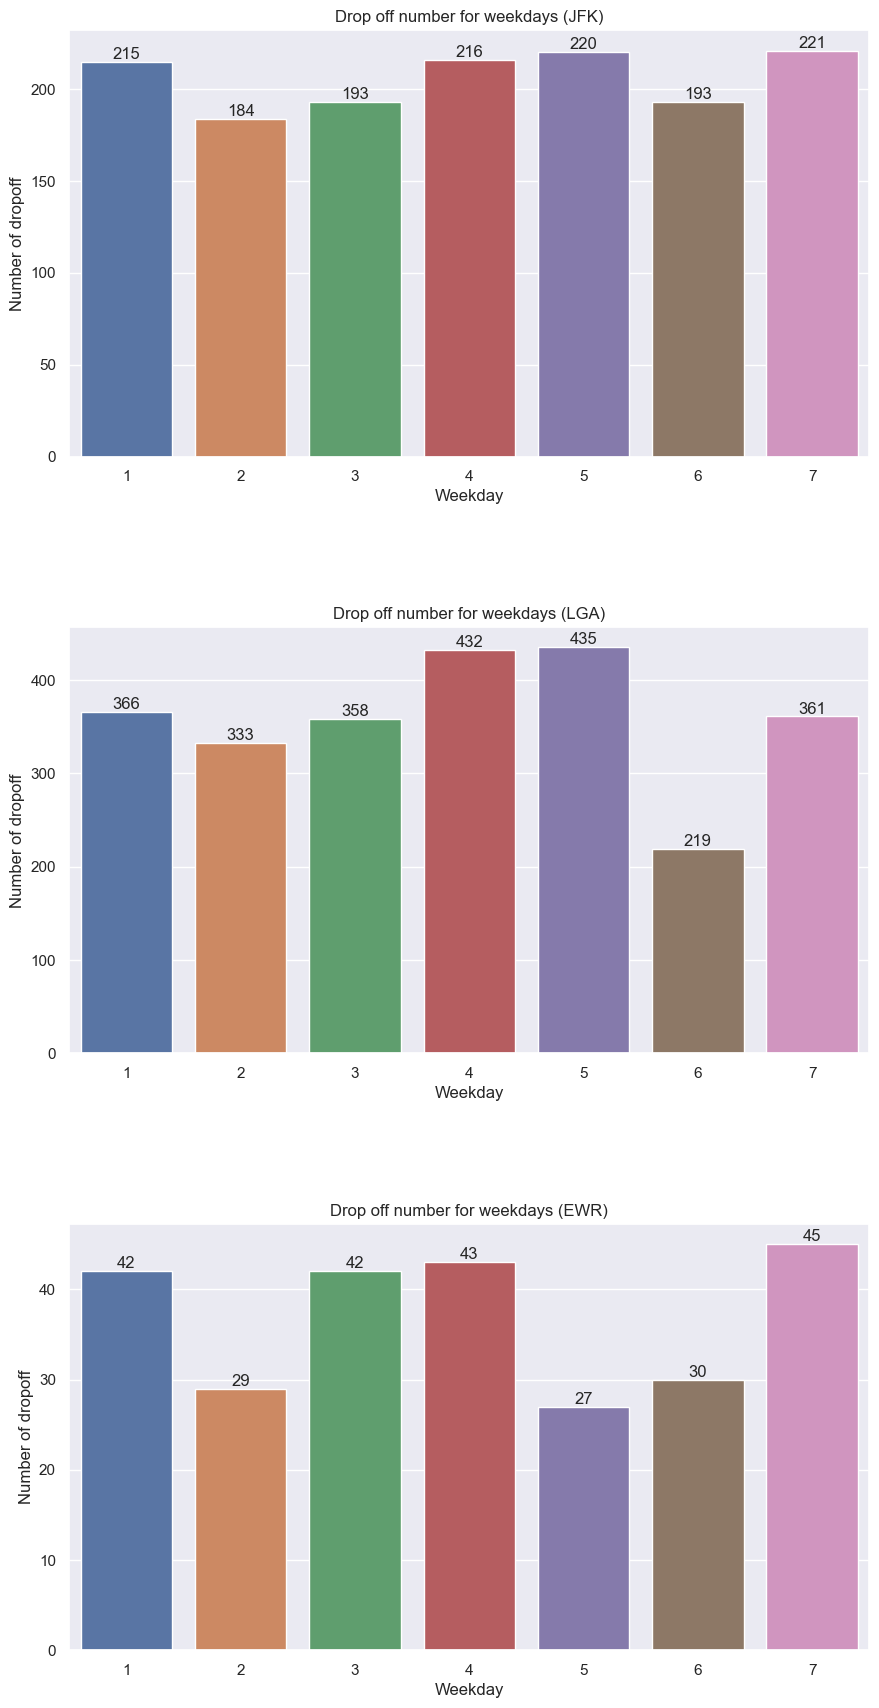

In [126]:
df_jfk, df_lga,df_ewr = get_data_for_airport()
plot_histograms_airport(df_jfk, df_lga,df_ewr)

According to the plot, Sunday is the most popular for drop offs for JFK. Thursday is the most popular for drop off for LGA. And Sunday is the most popular for drop offs for EWR.

### Problem 4

The function get_data_heatmap_alltrips() will return a dataframe which contain pickup latitude and longitude for all hired trips. And the function heatmap_alltrips(dataframe), will take the dataframe as an input, and then return a heatmap. However, since heatmap cannot directly display in visual studio code, we screenshot the result from jupyter notebook.

In [127]:
# use a more descriptive name for your function
def heatmap_alltrips(dataframe):
    """Take in dataframe and use KeplerGl to return a heat map"""
    gdf = gpd.GeoDataFrame(dataframe, geometry=gpd.points_from_xy
                            (dataframe.pickup_longitude, dataframe.pickup_latitude))
    map=KeplerGl(height=600, width=800)
    # use the dataframe to pull out values needed to plot
    map.add_data(data=gdf,name='Heatmap of all hired Trips')
    return map

In [4]:
def get_data_heatmap_alltrips():
    """Query pickup location data and return a dataframe"""

    # Query SQL database for the data needed.
    QUERY_heatmap_alltrips="""
    with all_trips as (
        SELECT pickup_longitude, 
            pickup_latitude 
        FROM taxi_trips
        union all
        SELECT pickup_longitude, 
            pickup_latitude 
        FROM uber_trips
    )
    SELECT * FROM all_trips    
    """
    df=pd.read_sql_query(QUERY_heatmap_alltrips,con=engine.connect())

    # You can put the data queried into a pandas dataframe, if you wish
    return df

In [129]:
heatmap_dataframe = get_data_heatmap_alltrips()
heatmap_alltrips(heatmap_dataframe)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Heatmap of all hired Trips': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, …

Display the heatmap

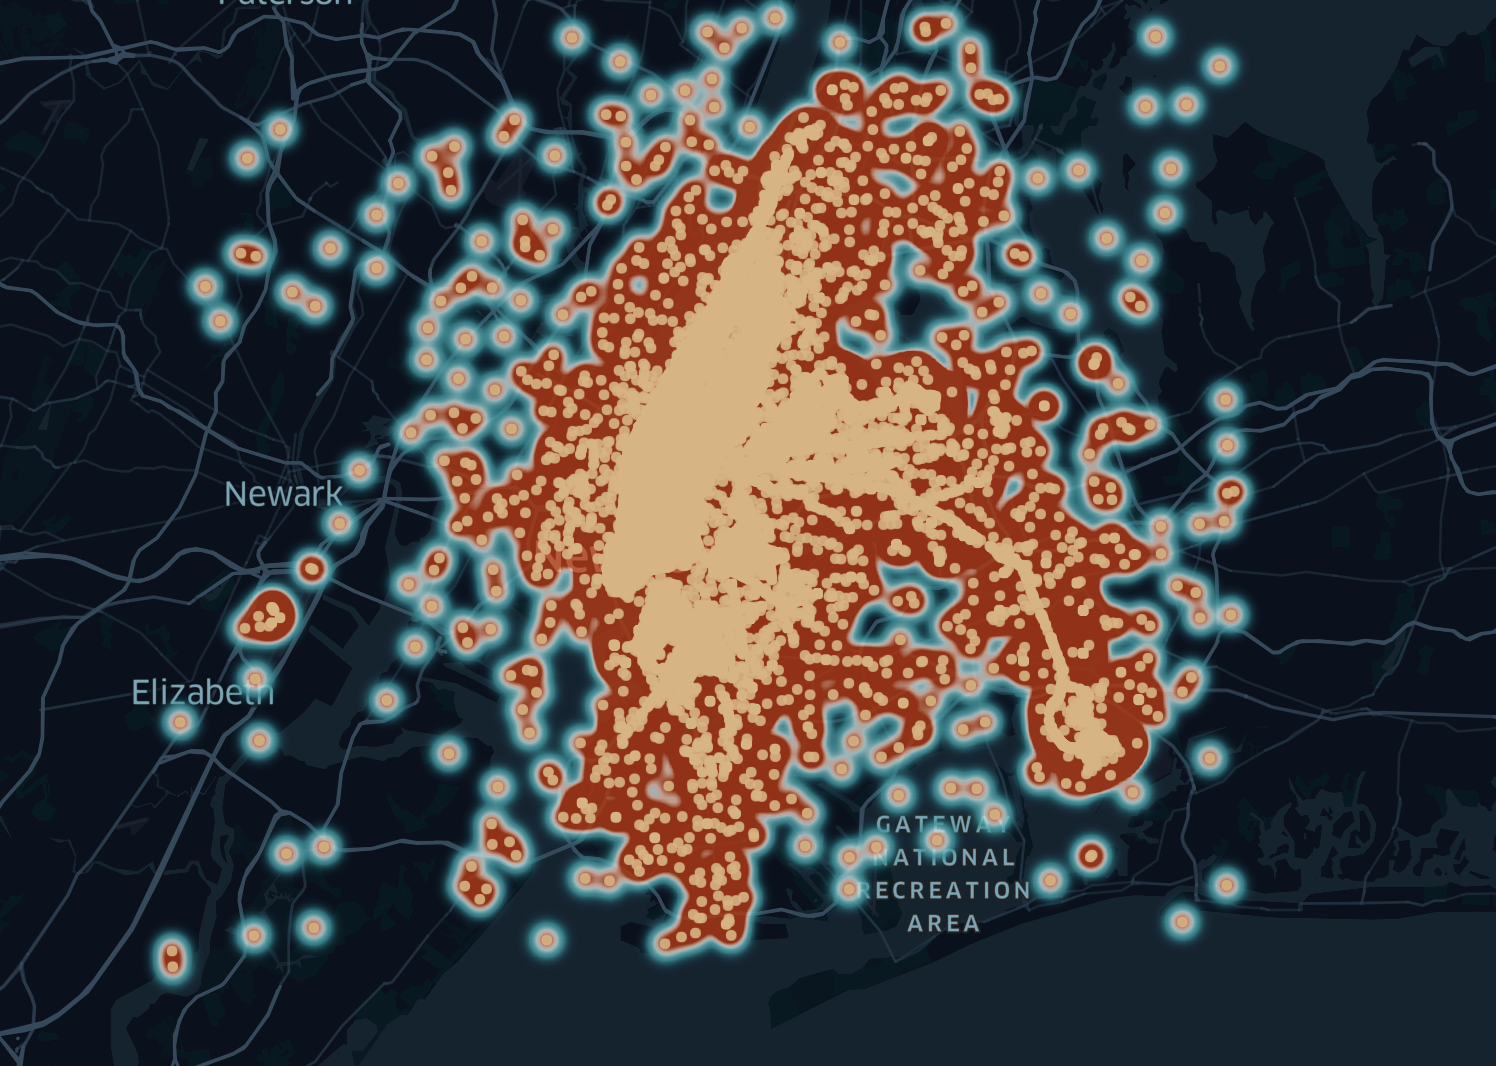

In [3]:
path="heatmap.png"
display(Image.open(path))

We noticed that trip amount is highest around manhattan area. And the trip amount is high arund Brooklyn and Queens.

### Problem 5

In order to explore the relationship between tip amount and distance for Yellow Taxi rides, we generate scatter plot and using linear fit. The function get_data_for_tipdistance() will return a dataframe countain tip_amount and distance. And the function plot_scatter_tipdistance(dataframe) will generate the scatter plot. We consider tip_amount>20 to be outliner. 

In [174]:
def plot_scatter_tipdistance(dataframe):
    """remove outlier and generate scatter plot"""
    #remove outlier
    dataframe=dataframe.loc[dataframe.tip_amount<=20]
    x=dataframe.distance
    y=dataframe.tip_amount
    plt.scatter(x, y, marker='o',alpha=0.5, cmap='viridis')
    m, b = np.polyfit(x, y, deg=1)
    plt.axline(xy1=(0, b), slope=m, label=f'$y = {m:.1f}x {b:+.1f}$',color="r")
    plt.xlabel("Distance (km)")
    plt.ylabel("Tip amount")
    plt.title("Scatter plot: tip amount vs distance")
    plt.legend()
    
    plt.show()

In [175]:
def get_data_for_tipdistance():
    """Query data from taxi_trips and return a dataframe"""
    # Query SQL database for the data needed.
    QUERY_tipdistance="""
    SELECT tip_amount, distance
    FROM taxi_trips
    """
    df=pd.read_sql_query(QUERY_tipdistance,con=engine.connect())

    # You can put the data queried into a pandas dataframe, if you wish
    return df

Scatterplot that exclude the outlier

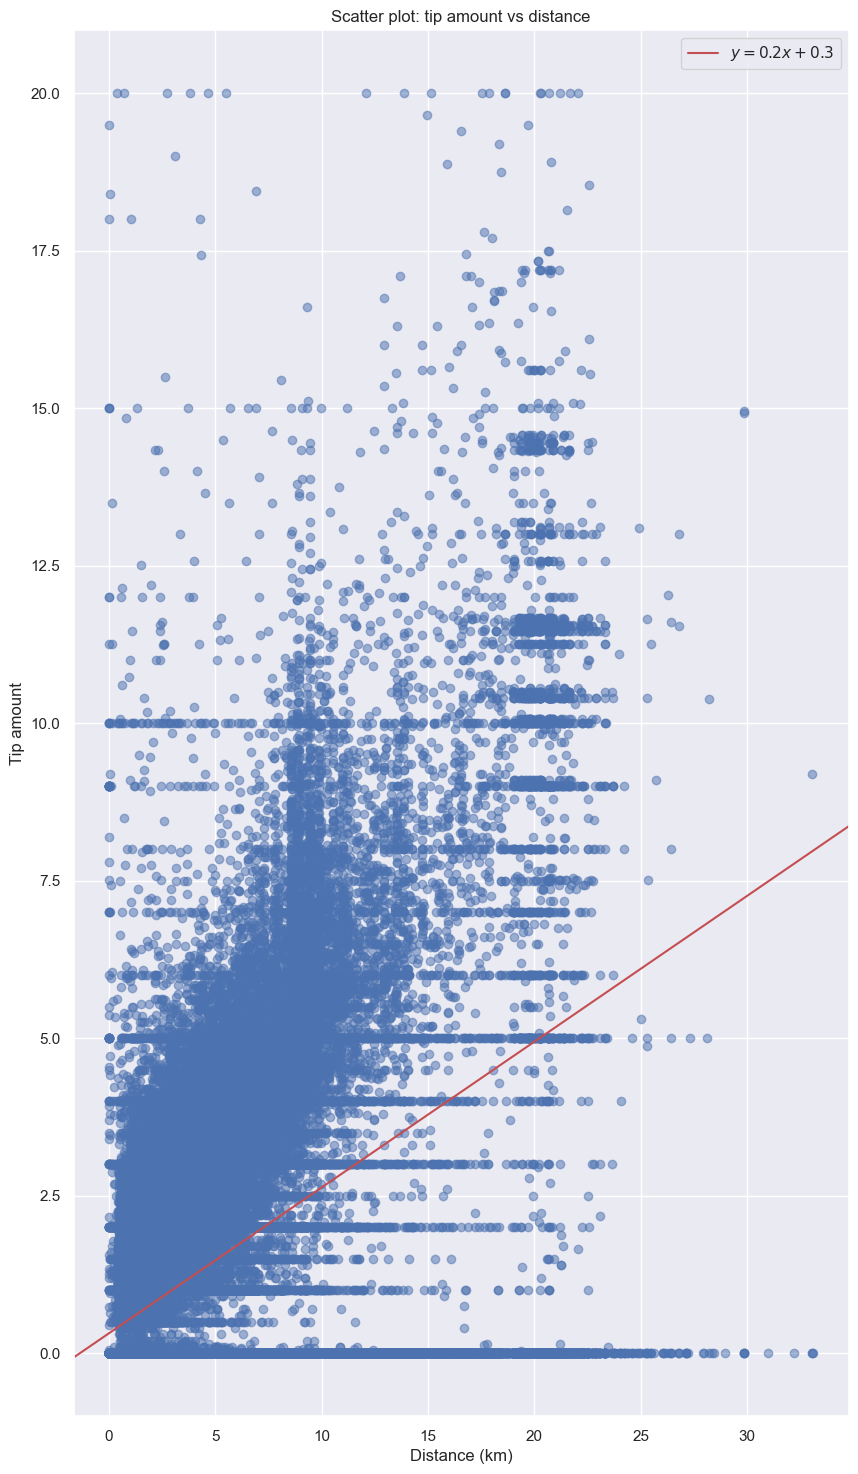

In [176]:
tipdistance_dataframe = get_data_for_tipdistance()
plot_scatter_tipdistance(tipdistance_dataframe)

The scatter plot  show a positive linear relationship between distance and tip amount. At the same time, many customers do not give tip (tip amount equal to 0). To better show the linear relationship (for customer who give tip), we drop the data with zero tip Amount. 

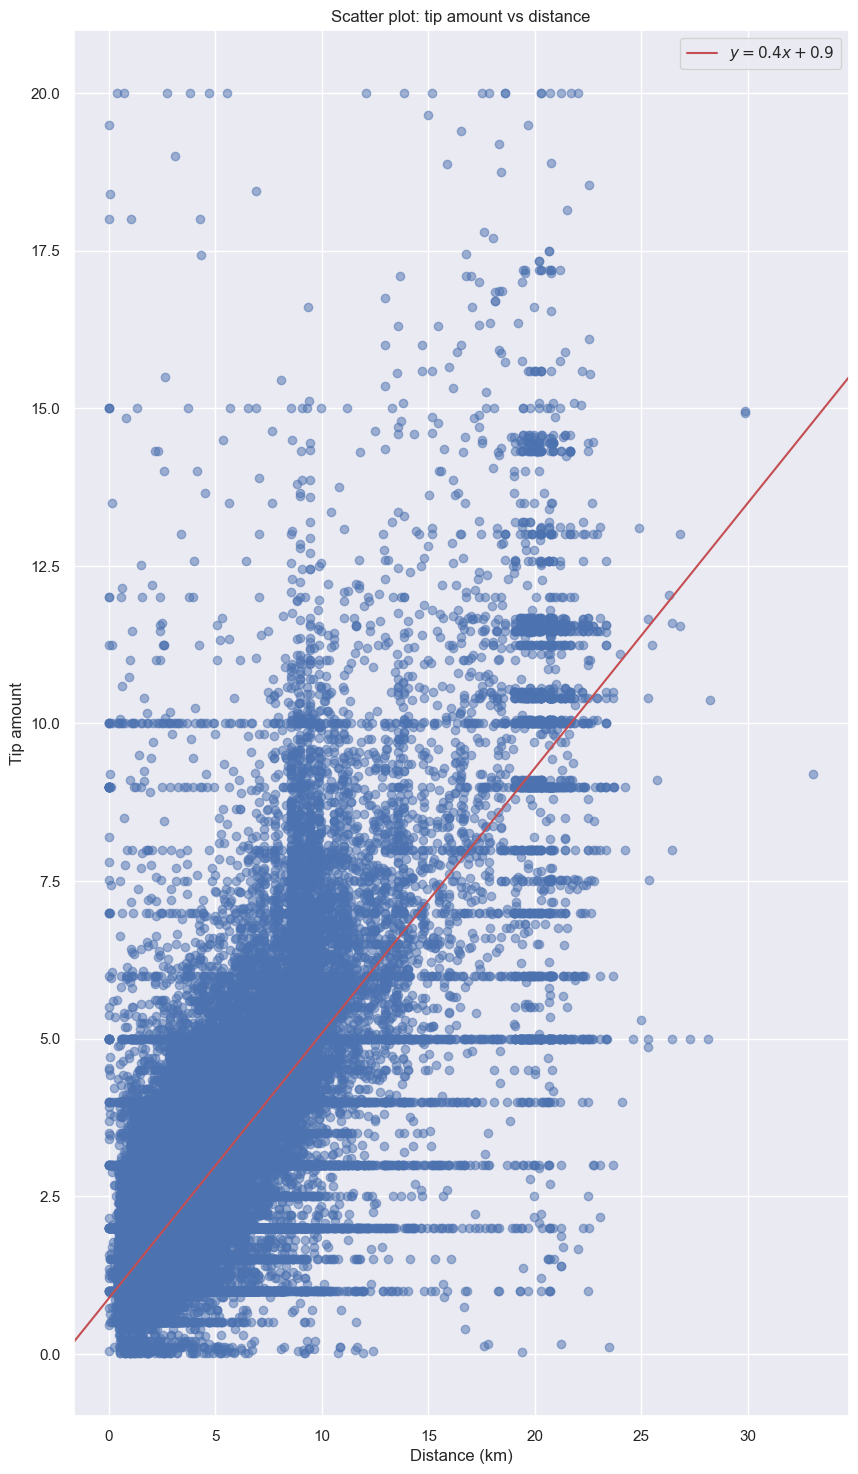

In [177]:
tip_Notzero_distance = get_data_for_tipdistance()
tip_Notzero_distance=tip_Notzero_distance.loc[tip_Notzero_distance.tip_amount>0]
plot_scatter_tipdistance(tip_Notzero_distance)

From the plot, we conclude that among customer who give tip, tip has a positive relationship with distance. Then distance increase, the tip amount increase.

### Problem 6

In [ ]:
# use a more descriptive name for your function
def plot_scatter_tip_percipitation(dataframe):
   
    
   
   
    
    plt.show()

In [ ]:
def get_data_for_tip_precipitation():
    # Query SQL database for the data needed.
    QUERY_tip_percipitation="""
    SELECT date from daily_weather
    """


    # You can put the data queried into a pandas dataframe, if you wish
    df=pd.read_sql_query( QUERY_tip_percipitation,con=engine.connect())    
    return df

In [ ]:
some_dataframe = get_data_for_tip_precipitation()
# plot_visual_n(some_dataframe)
some_dataframe.head()

OperationalError: (sqlite3.OperationalError) no such column: date
[SQL: 
    SELECT date from daily_weather
    ]
(Background on this error at: https://sqlalche.me/e/14/e3q8)